In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_04/'

## Семинар 4: "Сверточные сети"

ФИО: Иванов Максим Юрьевич

In [ ]:
import numpy as np
# from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [ ]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.sum(kernel[::-1] * signal[i:i+len(kernel)])

    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [ ]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

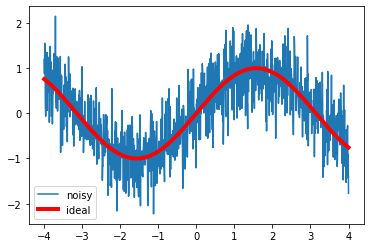

In [ ]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [ ]:
kernel = np.ones(5)
kernel /= kernel.shape[0]
denoised_signal = convolve(noisy_signal, kernel, 'same')

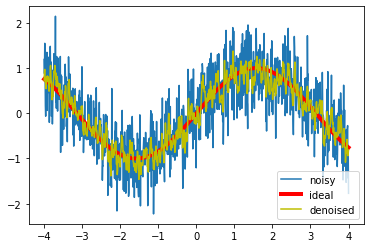

In [ ]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

Size = 66


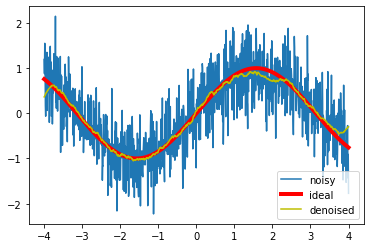

In [ ]:
min_error = None
min_size = 0
for size in range(2, noisy_signal.shape[0], 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    # error = np.abs(signal - denoised_signal).max()
    
    # print("ks = {}, error = {}".format(size, error))

    if min_error is None or error < min_error:
        min_error = error
        min_size = size

kernel = np.ones(min_size)
kernel /= kernel.shape[0]
denoised_signal = convolve(noisy_signal, kernel, 'same')

print(f'Size = {min_size}')

x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [ ]:
image = plt.imread(DIRECTORY + 'image.jpg')
image.shape

(1080, 1920, 3)

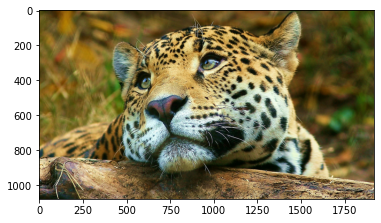

In [ ]:
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [ ]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

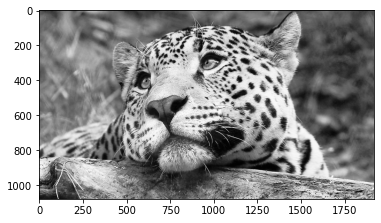

In [ ]:
bw_image = convolve(image.flatten(), color_to_bw, 'same')[::3].reshape(*image.shape[:2])
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [ ]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

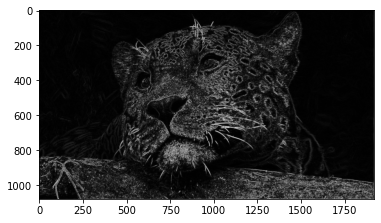

In [ ]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [ ]:
# signal - w, h, channels
# kernerl = in_ch, k_w, k_h, out_ch

def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    
    res = []
    for i in range(kernel.shape[-1]):
        r = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            r += convolve2d(signal[:, :, j], kernel[j, :, :, i], 'same')            
        
        res.append(r)
    
    return np.array(res).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [ ]:
#RGB -> BGR

kernels = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
]).reshape(3, 1, 1, 3)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

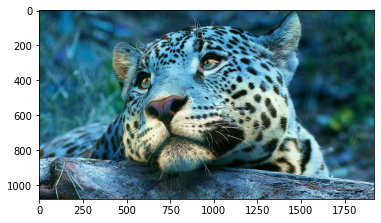

In [ ]:
res_image = t_convolve_bank(image.astype(float), kernels)

plt.imshow(res_image.astype('uint8'))

# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [ ]:
def pooling(image, func, w=2):
    assert image.ndim == 3

    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))

    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = func(image[i:i+w, j:j+w, k])

    return res

def maxpool(image, w=2):
    return pooling(image, np.max, w=w)
    

def medianpool(image, w=2):
    return pooling(image, np.median, w=w)

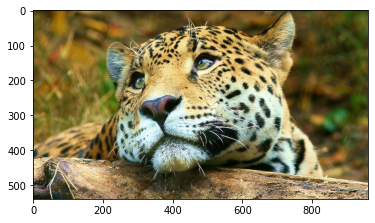

In [ ]:
res_image = maxpool(image.astype(float))

plt.imshow(res_image.astype('uint8'))

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

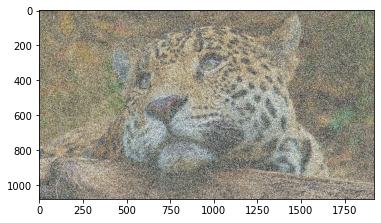

In [ ]:
frac = 0.6

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

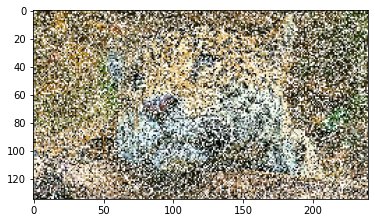

In [ ]:
clean_image = medianpool(res_image[::4, ::4, :].astype(float))

plt.imshow(clean_image.astype('uint8'))

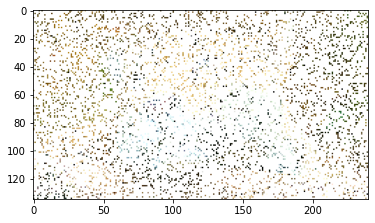

In [ ]:
clean_image = maxpool(res_image[::4, ::4, :].astype(float))

plt.imshow(clean_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Медианный пуллинг справился лучше (макспуллинг ставит белые пиксели)

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

#### Funcs

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


def get_datasets(download=False, transform=None, test=True):
    transform = transform or transforms.Compose([                     
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = MNIST('.', train=True, download=download, transform=transform)
    if test:
        test_dataset = MNIST('.', train=False, transform=transform)

    return train_dataset, test_dataset if test else train_dataset


def get_loaders(download=False, new_transform=None):
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                        ])
    train_dataset, test_dataset = get_datasets(download)

    if new_transform:
        new_train_dataset = get_datasets(download=True, transform=new_transform, test=False)
        train_dataset = train_dataset + new_train_dataset

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)# , collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)# , collate_fn=collate_fn)

    return train_loader, test_loader

In [ ]:
def train(network, train_loader=None, test_loader=None, epochs=10, 
          learning_rate=1e-3, plot=True, verbose=True, loss=None, 
          optimizer=None, clear_data=True,
          ravel_init=False, device='cpu', tolerate_keyboard_interrupt=True):
    
    train_loader = train_loader or base_train_loader
    test_loader = test_loader or base_test_loader
    loss = loss or nn.NLLLoss()
    optimizer = optimizer or torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                # if len(y) != 32:
                #     continue
                # X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy() if not isinstance(x, tuple) else x[0].view(x[0].shape[0], -1).numpy(), X))).reshape((-1, 784))
                # y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
                # X = X.view(X.shape[0], -1).numpy()
                # y = y.numpy()

                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1) == y.data.numpy()).mean())

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                # X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy(), X))).reshape((-1, 784))
                # y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
                # X = X.view(X.shape[0], -1).numpy()
                # y = y.numpy()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1) == y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            if verbose:
                if clear_data:
                    clear_output(True)
                print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [ ]:
def plot_analysis(network):
    wrong_X = []
    correct_y = []
    predicted_y = []
    logits = []
    for X, y in test_loader:
        prediction = network(X)
        prediction = np.exp(prediction.data.numpy())
        prediction /= prediction.sum(1, keepdims=True)
        for i in range(len(prediction)):
            if np.argmax(prediction[i]) != y[i]:
                wrong_X.append(X[i])
                correct_y.append(y[i])
                predicted_y.append(np.argmax(prediction[i]))
                logits.append(prediction[i][y[i]])
    wrong_X = np.row_stack(wrong_X)
    correct_y = np.row_stack(correct_y)[:, 0]
    predicted_y = np.row_stack(predicted_y)[:, 0]
    logits = np.row_stack(logits)[:, 0]

    plt.figure(figsize=(10, 5))
    order = np.argsort(logits)
    for i in range(21):
        plt.subplot(3, 7, i+1)
        plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
        plt.axis('off')

#### Solution

In [ ]:
base_train_loader, base_test_loader = get_loaders(download=True)

In [ ]:
## Usage example:
for X, y in base_train_loader:
    # X = np.asarray(list(map(lambda x: x.view(x.shape[0], -1).numpy() if not isinstance(x, tuple) else x[0].view(x[0].shape[0], -1).numpy(), X))).reshape((-1, 784))
    # y = np.asarray(list(map(lambda x: x if not isinstance(x, tuple) else x[1], y)))
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

    assert X.shape == (32, 784)
    assert y.shape == (32, )

    #print(X.shape)
    #print(y.shape)
print("All is OK")

All is OK


In [ ]:
# пример сверточной сети

class ConvClassifier(nn.Module):
    def __init__(self, image_size=28, channels=1):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
networks = {}

Epoch 9... (Train/Test) NLL: 0.077/0.083	Accuracy: 0.976/0.973


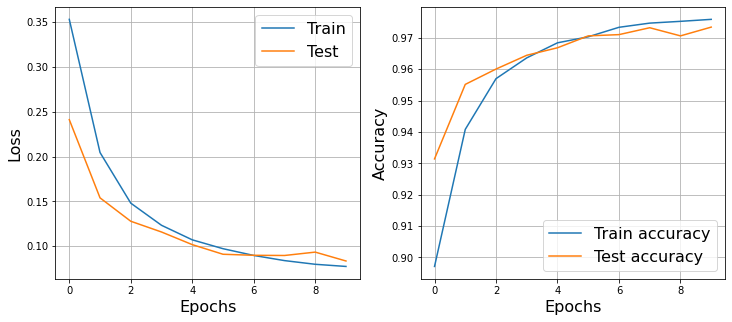

In [ ]:
name = 'Baseline'
networks[name] = ConvClassifier()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [ ]:
class ConvClassifier_arc_1(nn.Module):
    def __init__(self, image_size=28, channels=1):
        super(ConvClassifier_arc_1, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(3136, 10), nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.010/0.050	Accuracy: 0.997/0.988


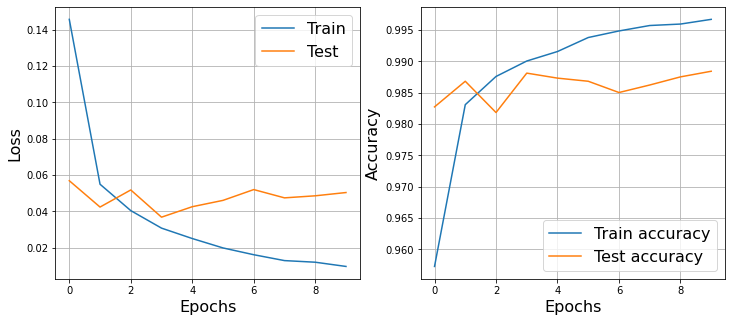

In [ ]:
name = 'Arc_1'
networks[name] = ConvClassifier_arc_1()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

In [ ]:
class ConvClassifier_arc_2(nn.Module):
    def __init__(self, image_size=28, channels=1):
        super(ConvClassifier_arc_2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(6272, 10), nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.018/0.058	Accuracy: 0.994/0.987


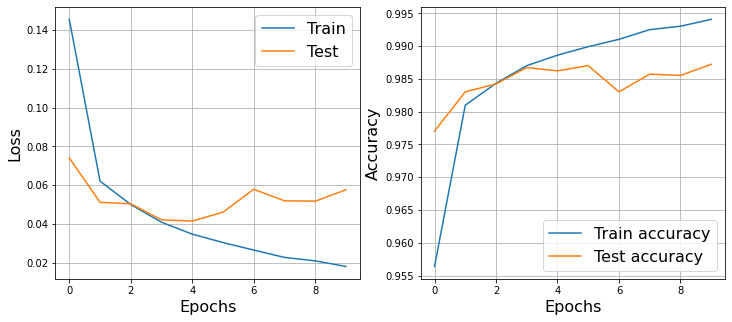

In [ ]:
name = 'Arc_2'
networks[name] = ConvClassifier_arc_2()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

На полносвязной нейронной сети на тесте я получал accuracy 0.976, здесь же я получил результат 0.988

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

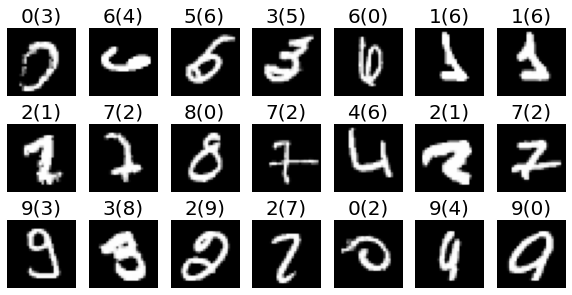

In [ ]:
plot_analysis(networks['Baseline'])

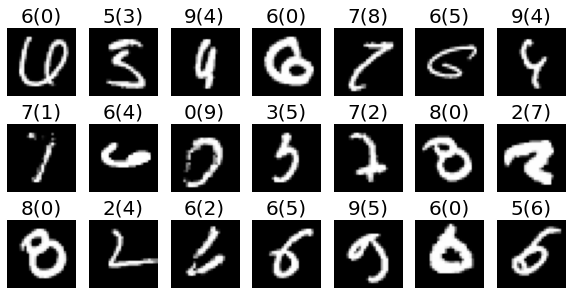

In [ ]:
plot_analysis(networks['Arc_1'])

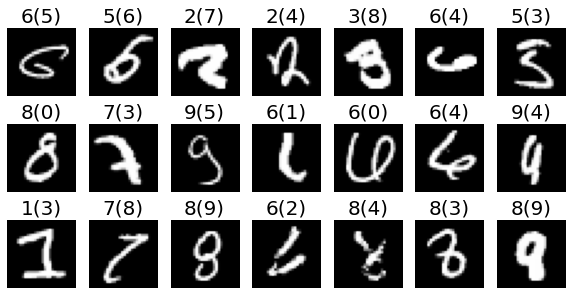

In [ ]:
plot_analysis(networks['Arc_2'])

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [ ]:
class ConvClassifier_arc_my(nn.Module):
    def __init__(self, image_size=28, channels=1):
        super(ConvClassifier_arc_my, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(288, 10), nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.018/0.035	Accuracy: 0.994/0.990


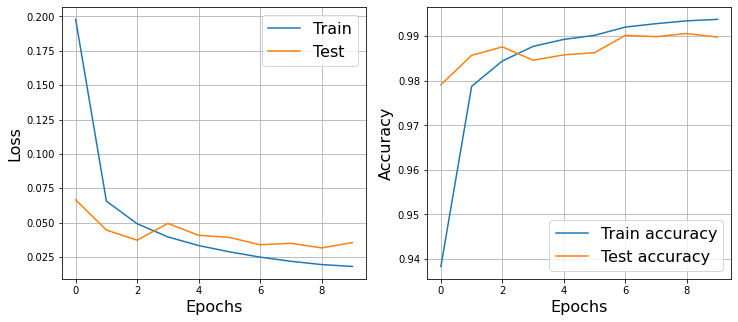

In [ ]:
name = 'Arc_my'
networks[name] = ConvClassifier_arc_my()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = train(networks[name])

У меня получилось улучшить результат до 0.990

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: